# Linear Regression Model Analysis

## Import library

In [934]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

## Load the MLB team data set

In [935]:
data_path = 'C:\\Users\\mikee\\Downloads\\Coursera\\IBM Machine Learning\\Supervised\\baseballdatabank-master\\core\\Teams.csv'
raw_teams_df = pd.read_csv(data_path)
raw_teams_df.shape
raw_teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 48 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   yearID          2955 non-null   int64  
 1   lgID            2905 non-null   object 
 2   teamID          2955 non-null   object 
 3   franchID        2955 non-null   object 
 4   divID           1438 non-null   object 
 5   Rank            2955 non-null   int64  
 6   G               2955 non-null   int64  
 7   Ghome           2556 non-null   float64
 8   W               2955 non-null   int64  
 9   L               2955 non-null   int64  
 10  DivWin          1410 non-null   object 
 11  WCWin           774 non-null    object 
 12  LgWin           2927 non-null   object 
 13  WSWin           2598 non-null   object 
 14  R               2955 non-null   int64  
 15  AB              2955 non-null   int64  
 16  H               2955 non-null   int64  
 17  2B              2955 non-null   i

## Load salary data set

In [936]:
data_path_salaries = 'C:\\Users\\mikee\\Downloads\\Coursera\\IBM Machine Learning\\Supervised\\baseballdatabank-master\\core\\Salaries.csv'
raw_salaries_df = pd.read_csv(data_path_salaries)
raw_salaries_df.shape
raw_salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26428 entries, 0 to 26427
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   yearID    26428 non-null  int64 
 1   teamID    26428 non-null  object
 2   lgID      26428 non-null  object
 3   playerID  26428 non-null  object
 4   salary    26428 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.0+ MB


## Data cleansing and feature engineering

### Extract 1985 ~ 2012 data

In [937]:
# Extract 1985-2012 data

# Make a data copy
team_df = raw_teams_df.copy(deep=True)
team_df = team_df.loc[(team_df['yearID']>1984) & (team_df['yearID']<2013)]
# print(team_df.shape)

# Remove unnecessary columns
unnecessary_columns = ['park', # Name of team's home ballpark
                       'teamIDBR', # Team ID used by Baseball Reference website
                       'teamIDlahman45', # Team ID used in Lahman database version 4.5
                       'teamIDretro'] # Team ID used by Retrosheet
team_df.drop(columns=unnecessary_columns, axis=1, inplace=True)
print(team_df.shape)

(798, 44)


### Merge teams data set with salaries data set

In [938]:
# Here we merge the teams data set with salaries data set
# so that we can put into team salaries data as indepedent variable.
salaries_df = raw_salaries_df.copy(deep=True)
salaries_df = salaries_df.loc[(salaries_df['yearID']>1984) & (salaries_df['yearID']<2013)]
aggregated_salaries_df = salaries_df.groupby(by=['yearID','teamID'], axis=0, as_index=False).sum()
aggregated_salaries_df

team_df = team_df.merge(right=aggregated_salaries_df, on=['yearID','teamID'])
team_df.head()


,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,BBA,SOA,E,DP,FP,name,attendance,BPF,PPF,salary
0,1985,NL,ATL,ATL,W,5,162,81.0,66,96,...,642,776,159,197,0.976,Atlanta Braves,1350137.0,105,106,14807000
1,1985,AL,BAL,BAL,E,4,161,81.0,83,78,...,568,793,129,168,0.979,Baltimore Orioles,2132387.0,97,97,11560712
2,1985,AL,BOS,BOS,E,5,163,81.0,81,81,...,540,913,145,161,0.977,Boston Red Sox,1786633.0,104,104,10897560
3,1985,AL,CAL,ANA,W,2,162,79.0,90,72,...,514,767,112,202,0.982,California Angels,2567427.0,100,100,14427894
4,1985,AL,CHA,CHW,W,3,163,81.0,85,77,...,569,1023,111,152,0.982,Chicago White Sox,1669888.0,104,104,9846178


In [939]:
# Copy the main data set
main_df = team_df.copy(deep=True)
# main_df.shape
main_df.info()
# main_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 797
Data columns (total 45 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yearID      798 non-null    int64  
 1   lgID        798 non-null    object 
 2   teamID      798 non-null    object 
 3   franchID    798 non-null    object 
 4   divID       798 non-null    object 
 5   Rank        798 non-null    int64  
 6   G           798 non-null    int64  
 7   Ghome       798 non-null    float64
 8   W           798 non-null    int64  
 9   L           798 non-null    int64  
 10  DivWin      770 non-null    object 
 11  WCWin       534 non-null    object 
 12  LgWin       770 non-null    object 
 13  WSWin       770 non-null    object 
 14  R           798 non-null    int64  
 15  AB          798 non-null    int64  
 16  H           798 non-null    int64  
 17  2B          798 non-null    int64  
 18  3B          798 non-null    int64  
 19  HR          798 non-null    i

In [940]:
# Check missing data
# Find out columns with null value
s = main_df.isna().sum()
na_columns = [x for x in s.index if s[x]>0]
na_columns
print('Columns with null values are {}'.format(na_columns))

Columns with null values are ['DivWin', 'WCWin', 'LgWin', 'WSWin']


#### In 1994 the season was interrupted due to strike, therefore there was no division, league and world series winner. Also 1994 was the first yeart to introduce wild card.

#### The wild card was first instituted in MLB in 1994, with one wild card team per league advancing to the Division Series in the postseason to face a division winner. In 2012, the system was modified to add a second wild card team per league and pit each league's wild card teams against each other in a play-in game — the MLB Wild Card Game — the winner of which would then advance to the Division Series and play the team with the best record. 

#### For missing DivWin, LgWin, and WSWin values in 1994, we reset them to N. For missing WCWin values from 1985 to 1994, we also reset them to N. 

In [941]:
# check these columns
for na_column in na_columns:
    print(na_column + ' : ' + str(main_df[na_column].unique()))
# Fix the nan value to N 
# DivWin, LgWin WSWin are missing in 1994 due to the strike, so we fix it to N.
# We also set N to wild card win (WCWin) since it was first introduced in 1994.
main_df.replace(np.nan, 'N', inplace=True)
# check the fixed data set; there should be no nan now.
main_df[['DivWin','WCWin','LgWin','WSWin']].info()

DivWin : ['N' 'Y' nan]
WCWin : [nan 'N' 'Y']
LgWin : ['N' 'Y' nan]
WSWin : ['N' 'Y' nan]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 797
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DivWin  798 non-null    object
 1   WCWin   798 non-null    object
 2   LgWin   798 non-null    object
 3   WSWin   798 non-null    object
dtypes: object(4)
memory usage: 31.2+ KB


In [942]:
# Transform categorical data to numerical one
# Check object type columns
object_columns = []
s = main_df.dtypes
y = main_df.columns
for i,j in zip(s,y):
    if(i == object):
        object_columns.append(j)
        print(j)
        print(main_df[j].unique())

# main_df[object_columns]

lgID
['NL' 'AL']
teamID
['ATL' 'BAL' 'BOS' 'CAL' 'CHA' 'CHN' 'CIN' 'CLE' 'DET' 'HOU' 'KCA' 'LAN'
 'MIN' 'ML4' 'MON' 'NYA' 'NYN' 'OAK' 'PHI' 'PIT' 'SDN' 'SEA' 'SFN' 'SLN'
 'TEX' 'TOR' 'COL' 'FLO' 'ANA' 'ARI' 'MIL' 'TBA' 'LAA' 'WAS' 'MIA']
franchID
['ATL' 'BAL' 'BOS' 'ANA' 'CHW' 'CHC' 'CIN' 'CLE' 'DET' 'HOU' 'KCR' 'LAD'
 'MIN' 'MIL' 'WSN' 'NYY' 'NYM' 'OAK' 'PHI' 'PIT' 'SDP' 'SEA' 'SFG' 'STL'
 'TEX' 'TOR' 'COL' 'FLA' 'ARI' 'TBD']
divID
['W' 'E' 'C']
DivWin
['N' 'Y']
WCWin
['N' 'Y']
LgWin
['N' 'Y']
WSWin
['N' 'Y']
name
['Atlanta Braves' 'Baltimore Orioles' 'Boston Red Sox' 'California Angels'
 'Chicago White Sox' 'Chicago Cubs' 'Cincinnati Reds' 'Cleveland Indians'
 'Detroit Tigers' 'Houston Astros' 'Kansas City Royals'
 'Los Angeles Dodgers' 'Minnesota Twins' 'Milwaukee Brewers'
 'Montreal Expos' 'New York Yankees' 'New York Mets' 'Oakland Athletics'
 'Philadelphia Phillies' 'Pittsburgh Pirates' 'San Diego Padres'
 'Seattle Mariners' 'San Francisco Giants' 'St. Louis Cardinals'
 'Texas Ra

In [943]:
# Transform categorical data
main_df['DivWin'].replace(to_replace={'N':0, 'Y':1}, inplace=True)
main_df['WCWin'].replace(to_replace={'N':0, 'Y':1}, inplace=True)
main_df['LgWin'].replace(to_replace={'N':0, 'Y':1}, inplace=True)
main_df['WSWin'].replace(to_replace={'N':0, 'Y':1}, inplace=True)
main_df[['DivWin', 'WCWin', 'LgWin', 'WSWin']]

,DivWin,WCWin,LgWin,WSWin
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
793,0,1,0,0
794,0,0,0,0
795,0,1,0,0
796,0,0,0,0


In [944]:
# Some object columns such as teamID, franchID, name are for descriptive usage
# and is no need to transform to dummy columns.
# Therefore we only transform lgID, divID
object_columns = ['lgID', 'divID']
main_df = pd.get_dummies(data=main_df, columns=object_columns, drop_first=False)

In [945]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 797
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yearID      798 non-null    int64  
 1   teamID      798 non-null    object 
 2   franchID    798 non-null    object 
 3   Rank        798 non-null    int64  
 4   G           798 non-null    int64  
 5   Ghome       798 non-null    float64
 6   W           798 non-null    int64  
 7   L           798 non-null    int64  
 8   DivWin      798 non-null    int64  
 9   WCWin       798 non-null    int64  
 10  LgWin       798 non-null    int64  
 11  WSWin       798 non-null    int64  
 12  R           798 non-null    int64  
 13  AB          798 non-null    int64  
 14  H           798 non-null    int64  
 15  2B          798 non-null    int64  
 16  3B          798 non-null    int64  
 17  HR          798 non-null    int64  
 18  BB          798 non-null    float64
 19  SO          798 non-null    f

In [946]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 0 to 797
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yearID      798 non-null    int64  
 1   teamID      798 non-null    object 
 2   franchID    798 non-null    object 
 3   Rank        798 non-null    int64  
 4   G           798 non-null    int64  
 5   Ghome       798 non-null    float64
 6   W           798 non-null    int64  
 7   L           798 non-null    int64  
 8   DivWin      798 non-null    int64  
 9   WCWin       798 non-null    int64  
 10  LgWin       798 non-null    int64  
 11  WSWin       798 non-null    int64  
 12  R           798 non-null    int64  
 13  AB          798 non-null    int64  
 14  H           798 non-null    int64  
 15  2B          798 non-null    int64  
 16  3B          798 non-null    int64  
 17  HR          798 non-null    int64  
 18  BB          798 non-null    float64
 19  SO          798 non-null    f

In [947]:
# Feature engineering with domain data
# Create domain data
# Calculate OPS, OBP and SLG as critical batting indexes.
# OPS = OBP + SLG
# OBP (On-Base Percentage) =（H + BB + HBP）/（AB + BB + HBP + SF）
# SLG (Slugging Percentage) = ((1*H)+(2*2B)+(3*3B)+(4*HR))/AB
main_df['OBP'] = (main_df['H']+main_df['BB']+main_df['HBP'])/(main_df['AB']+main_df['BB']+main_df['HBP']+main_df['SF'])
main_df['SLG'] = ((main_df['H'])+(2*main_df['2B'])+(3*main_df['3B'])+(4*main_df['HR']))/main_df['AB']
main_df['OPS'] = main_df['OBP'] + main_df['SLG']
print(main_df.shape)
main_df

(798, 51)


,yearID,teamID,franchID,Rank,G,Ghome,W,L,DivWin,WCWin,...,PPF,salary,lgID_AL,lgID_NL,divID_C,divID_E,divID_W,OBP,SLG,OPS
0,1985,ATL,ATL,5,162,81.0,66,96,0,0,...,106,14807000,0,1,0,0,1,0.314881,0.429425,0.744306
1,1985,BAL,BAL,4,161,81.0,83,78,0,0,...,97,11560712,1,0,0,1,0,0.335599,0.514954,0.850552
2,1985,BOS,BOS,5,163,81.0,81,81,0,0,...,104,10897560,1,0,0,1,0,0.346522,0.513986,0.860508
3,1985,CAL,ANA,2,162,79.0,90,72,0,0,...,100,14427894,1,0,0,0,1,0.332738,0.459206,0.791945
4,1985,CHA,CHW,3,163,81.0,85,77,0,0,...,104,9846178,1,0,0,0,1,0.315143,0.470750,0.785893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,2012,SLN,STL,2,162,81.0,88,74,0,1,...,97,110300862,0,1,1,0,0,0.337542,0.507471,0.845013
794,2012,TBA,TBD,3,162,81.0,90,72,0,0,...,93,64173500,1,0,0,1,0,0.316691,0.478511,0.795202
795,2012,TEX,TEX,2,162,81.0,93,69,0,1,...,111,120510974,1,0,0,0,1,0.333603,0.541682,0.875285
796,2012,TOR,TOR,4,162,81.0,73,89,0,0,...,104,75009200,1,0,0,1,0,0.309241,0.491708,0.800949


In [948]:
# Prepare the "post" 2012 data for model validation
# Make a data copy
check_year=2013
end_year=2014
team1_df = raw_teams_df.copy(deep=True)
team1_df = team1_df.loc[(team1_df['yearID']>=check_year) & (team1_df['yearID']<=end_year)]
print(team_df.shape)

# Remove unnecessary columns
unnecessary_columns = ['park', # Name of team's home ballpark
                       'teamIDBR', # Team ID used by Baseball Reference website
                       'teamIDlahman45', # Team ID used in Lahman database version 4.5
                       'teamIDretro'] # Team ID used by Retrosheet
team1_df.drop(columns=unnecessary_columns, axis=1, inplace=True)

salaries1_df = raw_salaries_df.copy(deep=True)
salaries1_df = salaries1_df.loc[(salaries1_df['yearID']>=check_year) & (salaries1_df['yearID']<=end_year)]
aggregated_salaries1_df = salaries1_df.groupby(by=['yearID','teamID'], axis=0, as_index=False).sum()
aggregated_salaries1_df

team_df1 = team1_df.merge(right=aggregated_salaries1_df, on=['yearID','teamID'])
team_df1.head()

# Transform categorical data
team_df1['DivWin'].replace(to_replace={'N':0, 'Y':1}, inplace=True)
team_df1['WCWin'].replace(to_replace={'N':0, 'Y':1}, inplace=True)
team_df1['LgWin'].replace(to_replace={'N':0, 'Y':1}, inplace=True)
team_df1['WSWin'].replace(to_replace={'N':0, 'Y':1}, inplace=True)
team_df1[['DivWin', 'WCWin', 'LgWin', 'WSWin']]

dummy_columns = ['lgID', 'divID']
team_df1 = pd.get_dummies(data=team_df1, columns=dummy_columns, drop_first=False)

team_df1['OBP'] = (team_df1['H']+team_df1['BB']+team_df1['HBP'])/(team_df1['AB']+team_df1['BB']+team_df1['HBP']+team_df1['SF'])
team_df1['SLG'] = ((team_df1['H'])+(2*team_df1['2B'])+(3*team_df1['3B'])+(4*team_df1['HR']))/team_df1['AB']
team_df1['OPS'] = team_df1['OBP'] + team_df1['SLG']
# make sure the shape/column is identical to main data set.
print(team_df1.shape)
team_df1.info()

(798, 45)
(60, 51)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yearID      60 non-null     int64  
 1   teamID      60 non-null     object 
 2   franchID    60 non-null     object 
 3   Rank        60 non-null     int64  
 4   G           60 non-null     int64  
 5   Ghome       60 non-null     float64
 6   W           60 non-null     int64  
 7   L           60 non-null     int64  
 8   DivWin      60 non-null     int64  
 9   WCWin       60 non-null     int64  
 10  LgWin       60 non-null     int64  
 11  WSWin       60 non-null     int64  
 12  R           60 non-null     int64  
 13  AB          60 non-null     int64  
 14  H           60 non-null     int64  
 15  2B          60 non-null     int64  
 16  3B          60 non-null     int64  
 17  HR          60 non-null     int64  
 18  BB          60 non-null     float64
 19  SO          

In [949]:
# Check correlation
# corr_columns = ['W', 'L', 'salary', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B', '3B', \
#                 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', \
#                 'ER', 'ERA', 'CG', 'SHO', 'SV', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP']
columns = main_df.columns.tolist()
columns.remove('teamID')
columns.remove('franchID')
columns.remove('name')
main_df[columns].corr().sort_values(by=['W', 'L'], ascending=False)

,yearID,Rank,G,Ghome,W,L,DivWin,WCWin,LgWin,WSWin,...,PPF,salary,lgID_AL,lgID_NL,divID_C,divID_E,divID_W,OBP,SLG,OPS
W,0.058997,-0.759570,0.389737,0.386118,1.000000,-0.701145,0.580709,0.230986,0.348168,0.232024,...,-0.089053,0.256255,0.018804,-0.018804,-0.127771,0.068692,0.046717,0.406416,0.330551,0.369352
SV,0.066516,-0.491086,0.321677,0.317435,0.687579,-0.440848,0.385054,0.107683,0.240168,0.149955,...,-0.106472,0.148369,-0.031941,0.031941,-0.108667,0.033911,0.064634,0.107495,0.066542,0.081595
R,0.181228,-0.424542,0.378719,0.372218,0.582912,-0.290985,0.308543,0.202187,0.162831,0.110100,...,0.153844,0.293394,0.267188,-0.267188,0.050429,0.010399,-0.056549,0.773294,0.783522,0.821902
DivWin,0.054520,-0.638375,0.078738,0.084215,0.580709,-0.520748,1.000000,-0.104925,0.444408,0.308692,...,-0.050517,0.192970,0.008233,-0.008233,-0.007402,-0.010569,0.017487,0.286388,0.233107,0.260408
attendance,0.267977,-0.443292,0.168596,0.182442,0.508495,-0.378960,0.360431,0.159162,0.203013,0.143402,...,0.056542,0.579904,-0.088733,0.088733,-0.051401,-0.029028,0.076363,0.324381,0.315909,0.334935
H,0.184852,-0.197541,0.689684,0.675111,0.501754,0.030939,0.201641,0.120521,0.116135,0.088074,...,0.155400,0.254189,0.220296,-0.220296,0.028153,0.002093,-0.027798,0.500386,0.473081,0.505696
BB,-0.011392,-0.322952,0.353505,0.349701,0.492629,-0.220231,0.255003,0.185609,0.131853,0.080957,...,-0.092775,0.121371,0.053285,-0.053285,-0.115143,0.113500,-0.010322,0.627237,0.318675,0.422468
SHO,0.005675,-0.313106,0.200576,0.188482,0.484777,-0.330802,0.296759,0.046959,0.195257,0.151786,...,-0.181646,0.104230,-0.123646,0.123646,-0.189342,0.078875,0.092515,-0.163402,-0.210757,-0.208503
IPouts,0.125376,-0.000658,0.987979,0.966648,0.451171,0.312185,0.115989,0.045902,0.068610,0.042283,...,-0.036862,0.121675,-0.033231,0.033231,-0.071331,0.021349,0.043353,-0.124618,-0.097816,-0.110525
SOA,0.590656,-0.282856,0.447046,0.433432,0.418006,-0.071258,0.214272,0.160927,0.108110,0.086503,...,-0.060874,0.548706,-0.234300,0.234300,0.090289,-0.054212,-0.027251,0.054701,0.212407,0.179123


In [950]:
main_df.shape

(798, 51)

In [951]:
# Check for collinearity
def check_collinearity(X):
# Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

## Model selection

In [952]:
def check_score(y_true, y_predict):
    r2 = r2_score(y_true, y_predict)
    mse = mean_squared_error(y_true, y_predict)
    mae = mean_absolute_error(y_true, y_predict)
#     get_scatter(y_true, y_predict)
    return r2, mse, mae 

In [953]:
def get_scatter(y_test, y_hat, title='', marker='o'):
    yt = np.linspace(20, 140, 20)
    figure, axes = plt.subplots()
    figure.set_figheight(10)
    figure.set_figwidth(15)
    axes.scatter(y_test, y_hat, alpha=.5, marker=marker)
    axes.plot(y_test, y_test, linestyle='dashed', color='red')
    axes.set(xlabel='True value', 
             ylabel='Predictions',
             title=title);
    axes.set_yticks(yt)
    axes.set_xticks(yt)

In [954]:
def check_coef(estimator1, X, y, cv=kf):
    metrics = cross_validate(estimator1, X, y, cv=kf, return_estimator=True)
    intercepts = []
    coefs = []
    i=1
    for model in metrics['estimator']:
        intercept_ = model[2].intercept_
        intercepts.append(intercept_)
        coef_ = model[2].coef_
        coefs.append(coef_)
    return intercepts, coefs

In [955]:
def get_coef_info(intercepts, coefs):
    df = pd.DataFrame()
    intercept_list = []
    coef_sum_list = []
    coef_not_zero_list = []
    coef_amount_list = []
    for intercept, coef in zip(intercepts, coefs):
        tmp_degree.append(2)
        intercept_list.append(intercept)
        coef_sum_list.append(abs(coef).sum())
        coef_not_zero_list.append((coef!=0).sum())
        coef_amount_list.append(coef.shape[0])
    df['Intercept'] = intercept_list
    df['Coef_Sum'] = coef_sum_list
    df['Coef_Amount'] = coef_amount_list
    df['Coef_Not_Zero'] = coef_not_zero_list
    return df

In [956]:
columns = ['SB', 'CS', 'ERA', 'SV', 'FP', 'salary', 'OPS']
X = main_df[columns]
# X = main_df.drop(columns=['W', 'yearID', 'teamID', 'franchID', 'Rank', 'name'])
y = main_df['W']
# collinearity check
c = check_collinearity(X)
print(c.sort_values(by='VIF', ascending=False))

  variables         VIF
6       OPS  406.498714
4        FP  387.603739
2       ERA   93.536406
3        SV   38.159911
1        CS   22.076440
0        SB   17.510795
5    salary    4.139910


In [957]:
X1 = team_df1[columns]
y1 = team_df1['W']
# y1 = predict_df['W']

In [958]:
def validate_post(model, X, y):
    # predict post 2012 data
    print('Validate prediction on post 2012 data')
    y_hat_post = model.predict(X)
    r2, mse, mae = check_score(y, y_hat_post)
    print('The R2 score is {}'.format(r2))
    print('The MSE score is {}'.format(mse))
    print('The MAE score is {}'.format(mae))
    get_scatter(y, y_hat_post)

### Train test split and simple linear regression

In [959]:
# Train test split and linear regression
# Target is to predict winnings by independent variables
# W is our dependent variable, and also get rid of some irrelavant (descriptive) variables
df1 = pd.DataFrame()

degree_list=[]
alpha_list=[]
r2_list = []
mse_list = []
mae_list = []
model = []

# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
lg = LinearRegression()
lg.fit(X_train, y_train)
y_hat = lg.predict(X_test)
r2, mse, mae = check_score(y_test, y_hat)
model.append('Vanilla linear_train_test_split')
degree_list.append(0)
alpha_list.append(0)
r2_list.append(r2)
mse_list.append(mse)
mae_list.append(mae)

### Use KFold to generate train and test set

In [960]:
# Use KFold
fold=6
kf = KFold(n_splits=fold, shuffle=True, random_state=1)
r2s = []
mses = []
maes = []
coef_kf = []
kf_coef_df = pd.DataFrame()
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.values[train_index], X.values[test_index]
    y_train_kf, y_test_kf = y.values[train_index], y.values[test_index]
    lg.fit(X_train_kf, y_train_kf)
    y_hat_kf = lg.predict(X_test_kf)
    r2, mse, mae = check_score(y_test_kf, y_hat_kf)
    r2s.append(r2)
    mses.append(mse)
    maes.append(mae)
    coef_kf.append(lg.coef_)
#     print(lg.coef_)
   
kf_coef_df['coef'] = coef_kf
kf_coef_df['R2'] = r2s
print('The average R2 score is {}'.format(np.average(r2s)))
print('The average MSE score is {}'.format(np.average(mses)))
print('The average MAE score is {}'.format(np.average(maes)))

The average R2 score is 0.8069767205976724
The average MSE score is 27.246855420494814
The average MAE score is 3.8480840615681857


In [961]:
# Use KFold with standard scaler
# The result is very close to each other
# kf = KFold(n_splits=fold, shuffle=True, random_state=1)
scaler = StandardScaler()
r2s_s = []
mses_s = []
maes_s = []
coef_kf = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.values[train_index], X.values[test_index]
    y_train_kf, y_test_kf = y.values[train_index], y.values[test_index]
    X_train_kf_s = scaler.fit_transform(X_train_kf)
    X_test_kf_s = scaler.transform(X_test_kf)
    lg.fit(X_train_kf_s, y_train_kf)
    y_hat_kf = lg.predict(X_test_kf_s)
    r2, mse, mae = check_score(y_test_kf, y_hat_kf)
    r2s_s.append(r2)
    mses_s.append(mse)
    maes_s.append(mae)
print('The average R2 score with standard scaler is {}'.format(np.average(r2s_s)))
print('The average MSE score is {}'.format(np.average(mses_s)))
print('The average MAE score is {}'.format(np.average(maes_s)))

The average R2 score with standard scaler is 0.8069767205977
The average MSE score is 27.246855420496544
The average MAE score is 3.8480840615705945


### Linear regression using pipeline with Polynomial through cross_val_predict

In [962]:
# Try Pipeline with Polynomial through cross_val_predict
# kf = KFold(n_splits=6, shuffle=True, random_state=1)
degrees = np.linspace(1, 4, num=4)
coef_df = pd.DataFrame()
for degree in degrees:
    degree = degree.astype(np.int)
    p = PolynomialFeatures(degree=degree)
    estimator = Pipeline([("scaler", scaler),
                          ('polynomial', p),
                          ("regression", lg)])
    y_predict = cross_val_predict(estimator, X, y, cv=kf)
    r2, mse, mae = check_score(y, y_predict)
    model.append('Vanilla linear_cross_val_predict')
    degree_list.append(degree)
    alpha_list.append(0)
    r2_list.append(r2)
    mse_list.append(mse)
    mae_list.append(mae)
    print('The average R2 score with {} degree Polynomial using cross_val_predict with standard scaler is {}'.format(degree,r2))
    intercepts, coefs = check_coef(estimator, X, y, cv=kf)
    df2 = get_coef_info(intercepts, coefs)
    coef_df = coef_df.append(df2)
coef_df

The average R2 score with 1 degree Polynomial using cross_val_predict with standard scaler is 0.8107844242256144
The average R2 score with 2 degree Polynomial using cross_val_predict with standard scaler is 0.8189940083495032
The average R2 score with 3 degree Polynomial using cross_val_predict with standard scaler is 0.7717386032419475
The average R2 score with 4 degree Polynomial using cross_val_predict with standard scaler is -0.10349347343313697


,Intercept,Coef_Sum,Coef_Amount,Coef_Not_Zero
0,80.085714,20.162446,8,7
1,79.324812,20.661110,8,7
2,80.091729,20.685877,8,7
3,79.831579,20.195613,8,7
4,79.822556,20.731976,8,7
5,79.572932,20.569739,8,7
0,80.157839,28.134017,36,36
1,79.338715,28.459091,36,36
2,79.937691,29.556901,36,36
3,79.472956,28.714114,36,36


In [963]:
# Use KFold with standard scaler and Polynomial Feature for backup check.
# The result is better than KFold without Polynomial Feature
# degree = 2 generates the best outcome based on previous check.
p = PolynomialFeatures(degree=2)
scaler = StandardScaler()
r2s_s = []
mses_s = []
maes_s = []
coef_kf = []
for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf = X.values[train_index], X.values[test_index]
    y_train_kf, y_test_kf = y.values[train_index], y.values[test_index]
    X_train_kf_s = scaler.fit_transform(X_train_kf)
    X_test_kf_s = scaler.transform(X_test_kf)    
    X_train_kf_s_p = p.fit_transform(X_train_kf_s)
    lg.fit(X_train_kf_s_p, y_train_kf)
    y_hat_kf = lg.predict(p.transform(X_test_kf_s))
    r2, mse, mae = check_score(y_test_kf, y_hat_kf)
    r2s_s.append(r2)
    mses_s.append(mse)
    maes_s.append(mae)
print('The average R2 score with standard scaler is {}'.format(np.average(r2s_s)))
print('The average MSE score is {}'.format(np.average(mses_s)))
print('The average MAE score is {}'.format(np.average(maes_s)))

The average R2 score with standard scaler is 0.814838819542642
The average MSE score is 26.06468344141634
The average MAE score is 3.7967327312483747


### Regularization with Lasso and Ridge and hyperparameter tuning

In [964]:
# Hyperparameter tuning
# Try Lasso with Polynomial by cross_val_predict
alphas = np.geomspace(1e-10, 1e0, num=11)
# degree=4 and above will generate negative r2 score
degrees = np.linspace(1, 3, num=3)
for degree in degrees:
    degree = degree.astype(int)
    
    poly = PolynomialFeatures(degree=degree)
    # alphas
    for alpha in alphas:
#         print('The poly degree is {} and Lasso alpha is {}'.format(degree, alpha))
        lasso = Lasso(alpha=alpha, max_iter=1000000, random_state=1)
        estimator = Pipeline([('scaler', scaler), 
                              ('polynomial', poly),
                              ('regression', lasso)])      
        y_predict = cross_val_predict(estimator, X, y, cv=kf)
        r2, mse, mae = check_score(y, y_predict)
        model.append('Lasso')
        degree_list.append(degree)
        alpha_list.append(alpha)
        r2_list.append(r2)
        mse_list.append(mse)
        mae_list.append(mae)
        
        ridge = Ridge(alpha=alpha)
        estimator_ridge = Pipeline([('scaler', scaler), 
                              ('polynomial', poly),
                              ('regression', ridge)])
        y_predict_ridge = cross_val_predict(estimator_ridge, X, y, cv=kf)
        r2_ridge, mse_ridge, mae_ridge = check_score(y, y_predict_ridge)
        model.append('Ridge')
        degree_list.append(degree)
        alpha_list.append(alpha)
        r2_list.append(r2_ridge)
        mse_list.append(mse_ridge)
        mae_list.append(mae_ridge)
df1['Model'] = model
df1['Polynomial Degree'] = degree_list
df1['Alpha'] = alpha_list
df1['R2'] = r2_list
df1['MSE'] = mse_list
df1['MAE'] = mae_list
# df1.sort_values(by=['R2'], ascending=False)

df1.loc[(df1['Model']=='Lasso')|(df1['Model']=='Ridge')].sort_values(by=['R2'], ascending=False)

,Model,Polynomial Degree,Alpha,R2,MSE,MAE
45,Lasso,2,1.000000e-01,0.822517,25.557446,3.757648
43,Lasso,2,1.000000e-02,0.820106,25.904525,3.786644
41,Lasso,2,1.000000e-03,0.819121,26.046374,3.795319
48,Ridge,2,1.000000e+00,0.819058,26.055469,3.796518
39,Lasso,2,1.000000e-04,0.819007,26.062772,3.796592
...,...,...,...,...,...,...
56,Ridge,3,1.000000e-07,0.771739,32.869415,4.196827
54,Ridge,3,1.000000e-08,0.771739,32.869415,4.196827
52,Ridge,3,1.000000e-09,0.771739,32.869415,4.196827
50,Ridge,3,1.000000e-10,0.771739,32.869415,4.196827


### Comparison among models

In [965]:
df1.loc[(df1['Model']=='Vanilla linear_train_test_split')
       |(df1['Model']=='Vanilla linear_cross_val_predict')
       |((df1['Model']=='Lasso')&(df1['R2']>0.818))
       |((df1['Model']=='Ridge')&(df1['R2']>0.818))].sort_values(by=['R2'], ascending=False)

,Model,Polynomial Degree,Alpha,R2,MSE,MAE
45,Lasso,2,1.000000e-01,0.822517,25.557446,3.757648
43,Lasso,2,1.000000e-02,0.820106,25.904525,3.786644
41,Lasso,2,1.000000e-03,0.819121,26.046374,3.795319
48,Ridge,2,1.000000e+00,0.819058,26.055469,3.796518
39,Lasso,2,1.000000e-04,0.819007,26.062772,3.796592
46,Ridge,2,1.000000e-01,0.819001,26.063705,3.796704
37,Lasso,2,1.000000e-05,0.818995,26.064493,3.796719
44,Ridge,2,1.000000e-02,0.818995,26.064585,3.796730
35,Lasso,2,1.000000e-06,0.818994,26.064664,3.796731
42,Ridge,2,1.000000e-03,0.818994,26.064674,3.796732


The average R2 score with standard scaler is 0.8225165129075208
The average MSE score is 25.557446275461334
The average MAE score is 3.7576475702764456
The average R2 score with standard scaler is 0.7993742317629622
The average MSE score is 23.496565493981016
The average MAE score is 3.584726885157677


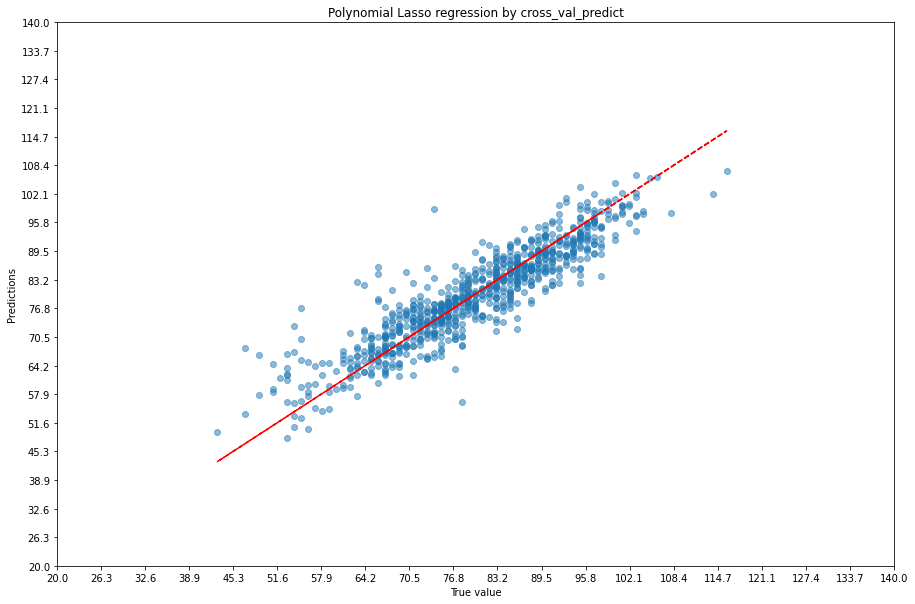

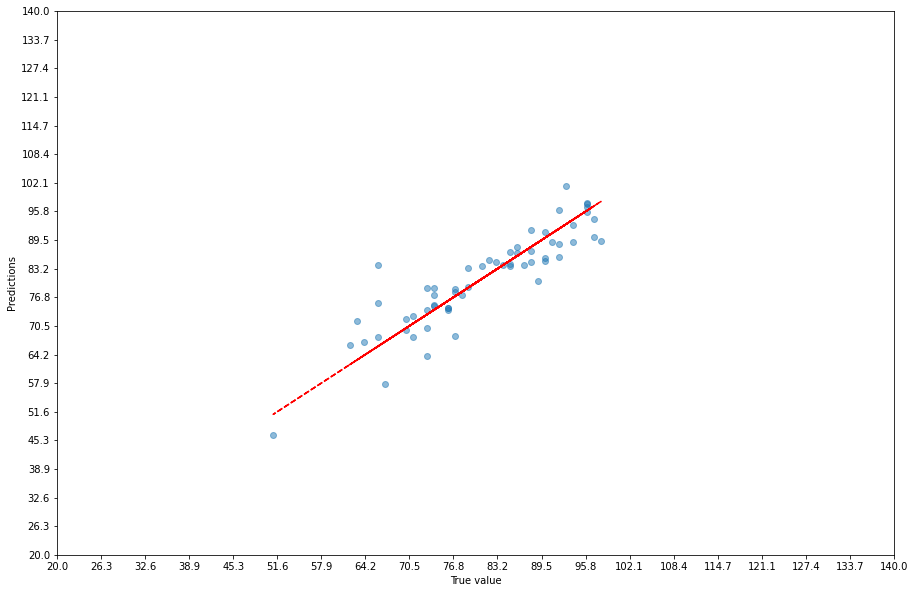

In [966]:
# With hyperparameter tuning it seems Lasso model with alpha value 0.1 and 2 degree polynomial is the choice
# plot our best Lasso
poly = PolynomialFeatures(degree=2)
lasso_ = Lasso(alpha=0.1, max_iter=1000000, random_state=1)
estimator = Pipeline([('scaler', scaler), 
                              ('polynomial', poly),
                              ('regression', lasso_)])      
y_predict_lasso = cross_val_predict(estimator, X, y, cv=kf)
r2, mse, mae = check_score(y, y_predict_lasso)
print('The average R2 score with standard scaler is {}'.format(r2))
print('The average MSE score is {}'.format(mse))
print('The average MAE score is {}'.format(mae))
get_scatter(y, y_predict_lasso, title='Polynomial Lasso regression by cross_val_predict')

# for post check on smaller data set
y_predict_lasso_post = cross_val_predict(estimator, X1, y1, cv=kf)
r2, mse, mae = check_score(y1, y_predict_lasso_post)
print('The average R2 score with standard scaler is {}'.format(r2))
print('The average MSE score is {}'.format(mse))
print('The average MAE score is {}'.format(mae))
get_scatter(y1, y_predict_lasso_post)

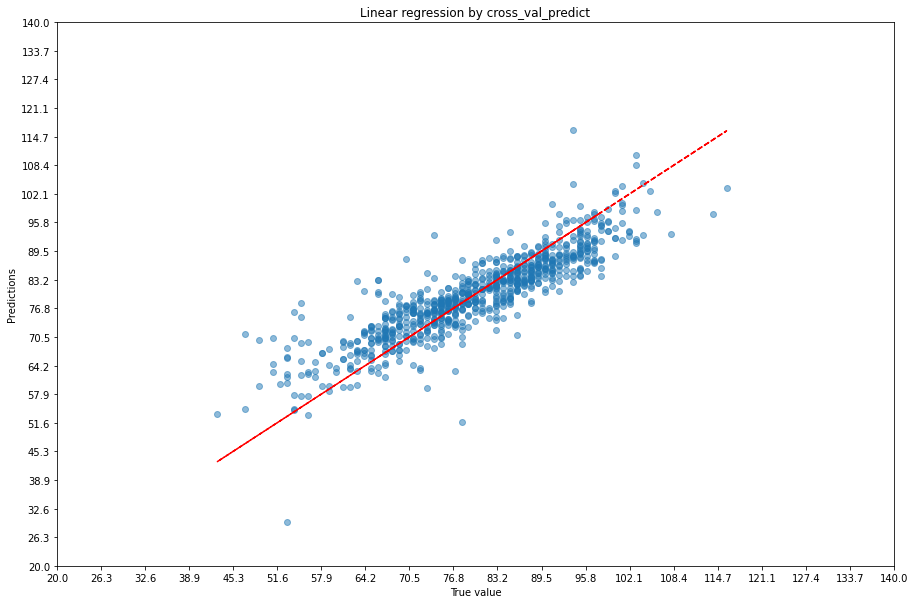

In [967]:
# plot linear regression (cross_val_predict) with degree 2 Polynomial
get_scatter(y, y_predict, title='Linear regression by cross_val_predict')

## Check on different data set size

Linear regression by cross_val_predict
The average R2 score is 0.8107844242256144
The average MSE score is 27.246855420496544
The average MAE score is 3.8480840615705945
For post check on Linear regression by cross_val_predict
The average R2 score is 0.8833940469810209
The average MSE score is 13.656468140530267
The average MAE score is 2.884856511413741


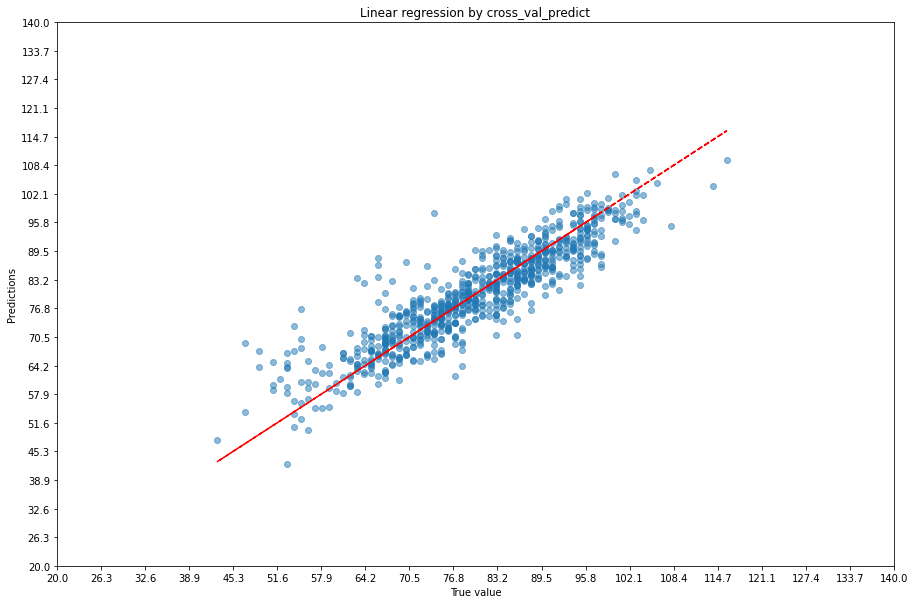

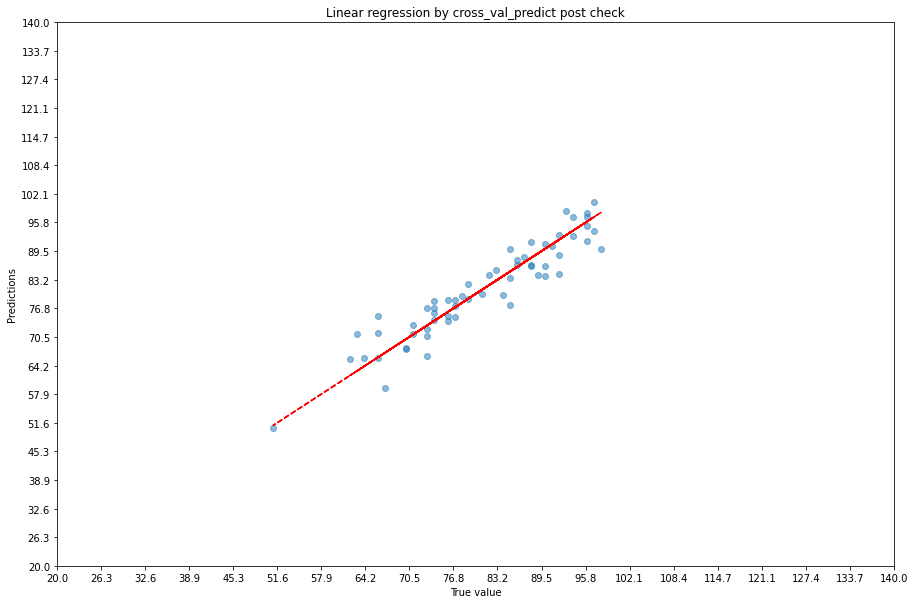

In [968]:
# for post check on smaller data set
p = PolynomialFeatures(degree=1)
estimator = Pipeline([("scaler", scaler),
                          ('polynomial', p),
                          ("regression", lg)])
y_predict = cross_val_predict(estimator, X, y, cv=kf)
r2, mse, mae = check_score(y, y_predict)
print('Linear regression by cross_val_predict')
print('The average R2 score is {}'.format(r2))
print('The average MSE score is {}'.format(mse))
print('The average MAE score is {}'.format(mae))
get_scatter(y, y_predict, title='Linear regression by cross_val_predict')

y_predict1 = cross_val_predict(estimator, X1, y1, cv=kf)
r2, mse, mae = check_score(y1, y_predict1)
print('For post check on Linear regression by cross_val_predict')
print('The average R2 score is {}'.format(r2))
print('The average MSE score is {}'.format(mse))
print('The average MAE score is {}'.format(mae))
get_scatter(y1, y_predict1, title='Linear regression by cross_val_predict post check')

In [969]:
# Get Lasso coefficient
poly = PolynomialFeatures(degree=2)
lasso_ = Lasso(alpha=0.1, max_iter=1000000, random_state=1)
estimator1 = Pipeline([('scaler', scaler), 
                              ('polynomial', poly),
                              ('regression', lasso_)])  

intercepts, coefs = check_coef(estimator1, X, y, cv=kf)
df3 = get_coef_info(intercepts, coefs)
df3

,Intercept,Coef_Sum,Coef_Amount,Coef_Not_Zero
0,79.962539,23.109046,36,21
1,79.127834,23.515627,36,24
2,79.869961,24.375593,36,23
3,79.480512,23.662302,36,25
4,79.587913,23.682548,36,21
5,79.174824,23.137316,36,19


In [970]:
# Get Ridge coefficient
poly = PolynomialFeatures(degree=2)
ridge_ = Ridge(alpha=0.1)
estimator1 = Pipeline([('scaler', scaler), 
                              ('polynomial', poly),
                              ('regression', ridge_)])
intercepts, coefs = check_coef(estimator1, X, y, cv=kf)
df4 = get_coef_info(intercepts, coefs)
df4 

,Intercept,Coef_Sum,Coef_Amount,Coef_Not_Zero
0,80.157477,28.125415,36,35
1,79.338309,28.449944,36,35
2,79.937564,29.546024,36,35
3,79.472594,28.703211,36,35
4,79.641568,27.526430,36,35
5,79.240735,28.059058,36,35


In [971]:
poly = PolynomialFeatures(degree=2)
elastic = ElasticNet(alpha=0.1)
estimator2 = Pipeline([('scaler', scaler), 
                              ('polynomial', poly),
                              ('regression', elastic)])
y_predict2 = cross_val_predict(estimator2, X, y, cv=kf)
r2, mse, mae = check_score(y, y_predict2)
print('Elastic regression by cross_val_predict')
print('The average R2 score is {}'.format(r2))
print('The average MSE score is {}'.format(mse))
print('The average MAE score is {}'.format(mae))
intercepts, coefs = check_coef(estimator2, X, y, cv=kf)
df5 = get_coef_info(intercepts, coefs)
df5 

Elastic regression by cross_val_predict
The average R2 score is 0.8191768083201039
The average MSE score is 26.03836042678374
The average MAE score is 3.82661512086831


,Intercept,Coef_Sum,Coef_Amount,Coef_Not_Zero
0,79.975488,23.024210,36,28
1,79.098546,23.427947,36,28
2,79.878424,24.413111,36,29
3,79.396107,23.755660,36,29
4,79.537852,23.396548,36,24
5,79.146400,23.095621,36,27
